# 멀티 모달 데이터 처리 - Amazon Bedrock Knowledge Bases를 활용한 텍스트 및 이미지의 엔드 투 엔드 예제

멀티 모달 RAG는 텍스트와 이미지, 차트, 다이어그램, 표 등의 시각적 데이터 모두에서 통찰력을 분석하고 활용할 수 있습니다. Bedrock Knowledge Bases는 고객이 자체 데이터 소스의 문맥 정보를 통합하여 매우 정확하고, 지연 시간이 짧으며, 안전하고 맞춤화된 생성형 AI 애플리케이션을 만들 수 있게 해주는 엔드 투 엔드 관리형 검색 증강 생성(RAG) 워크플로우를 제공합니다.

Bedrock Knowledge Bases는 텍스트와 시각적 데이터 모두에서 콘텐츠를 추출하고, 선택한 임베딩 모델을 사용하여 의미론적 임베딩을 생성한 후 선택한 벡터 저장소에 저장합니다. 이를 통해 사용자는 텍스트뿐만 아니라 시각적 데이터에서도 도출된 질문에 대한 답변을 검색하고 생성할 수 있습니다. 또한 검색된 결과에는 이제 시각적 데이터에 대한 출처 표시가 포함되어 생성된 출력물에 대한 투명성과 신뢰도가 향상됩니다.

다음 중 선택할 수 있습니다: 멀티모달 데이터에서 자동으로 콘텐츠를 추출하는 관리형 서비스인 Amazon Bedrock Data Automation(현재 프리뷰 중), 또는 기본 프롬프트를 커스터마이즈할 수 있는 유연성을 가진 Claude 3.5 Sonnet나 Claude 3 Haiku와 같은 FM.

이 노트북은 Amazon Bedrock Knowledge Bases를 사용하여 멀티모달 RAG를 구축하는 샘플 코드를 제공합니다.

#### 단계:
- S3에서 데이터를 읽고 쓰고 필요한 기반 모델에 접근하기 위한 필수 정책이 포함된 Knowledge Base 실행 역할 생성
- 풍부한 콘텐츠 문서가 포함된 knowledge base 생성
- knowledge base 내에 데이터 소스 생성
- KB API를 사용하여 수집 작업을 시작하면 데이터 소스에서 데이터를 읽고, Bedrock Data Automation 또는 기반 모델을 사용하여 문서(이미지, 차트, 표 등)를 파싱하고, 청크로 나누고, Amazon Titan Embeddings 모델을 사용하여 청크를 임베딩으로 변환한 다음 이러한 임베딩을 AOSS에 저장합니다. 이 모든 과정에서 데이터 파이프라인을 구축, 배포 및 관리할 필요가 없습니다.

데이터가 Bedrock Knowledge Base에서 사용 가능하게 되면 Amazon Bedrock에서 제공하는 Knowledge Base API를 사용하여 질의응답 애플리케이션을 구축할 수 있습니다.

#### 사전 요구 사항:

Amazon Bedrock Console에서 `Anthropic Claude 3 Sonnet`, `Amazon Nova Micro` 및 `Titan Text Embeddings V2` 모델에 대한 접근을 활성화했는지 확인하세요.

<div class="alert alert-block alert-info">
<b>참고:</b> "모든 셀 실행" 옵션을 사용하는 대신 노트북 셀을 한 번에 하나씩 실행해주세요.
</div>


### 0 - Setup
Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

Please ignore any pip dependency error (if you see any while installing libraries)

In [4]:
# %pip install --upgrade pip --quiet
# %pip install -r ../../requirements.txt --no-deps --quiet
# %pip install -r ../../requirements.txt --upgrade --quiet

In [5]:
# %pip install --upgrade boto3
import boto3
print(boto3.__version__)

1.39.16


In [6]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import os
import sys
import time
import boto3
import logging
import pprint
import json

# Set the path to import module
from pathlib import Path
current_path = Path().resolve()
current_path = current_path.parent
if str(current_path) not in sys.path:
    sys.path.append(str(current_path))
# Print sys.path to verify
# print(sys.path)

from utils.knowledge_base import BedrockKnowledgeBase

In [10]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

('us-west-2', '211125368524')

In [11]:
import time

# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name = f"bedrock-multi-modal-kb-{suffix}"
knowledge_base_description = "Multi-modal RAG knowledge base."

bucket_name = f'{knowledge_base_name}-{account_id}'
# intermediate_bucket_name = f'{knowledge_base_name}-mm-storage-{account_id}'
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"

#### You can add multiple data sources (S3, Sharepoint) to a multimodal Knowledge Base. For this notebook, we'll test Knowledge Base creation with S3 Bucket.


Each data source may have different pre-requisites, please refer to the AWS documetation for more information.

In [12]:
## Please uncomment the data sources that you want to add and update the placeholder values accordingly.

data_sources=[
                {"type": "S3", "bucket_name": bucket_name}, 

                # {"type": "SHAREPOINT", "tenantId": "888d0b57-69f1-4fb8-957f-e1f0bedf64de", "domain": "yourdomain",
                #   "authType": "OAUTH2_CLIENT_CREDENTIALS",
                #  "credentialsSecretArn": f"arn:aws::secretsmanager:{region_name}:secret:<<your_secret_name>>",
                #  "siteUrls": ["https://yourdomain.sharepoint.com/sites/mysite"]
                # },
            ]
                
pp = pprint.PrettyPrinter(indent=2)

### 1 - Create Knowledge Base with Multi modality

In [13]:
# For multi-modal RAG While instantiating BedrockKnowledgeBase, pass multi_modal= True and choose the parser you want to use

knowledge_base = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name}',
    kb_description=knowledge_base_description,
    data_sources=data_sources,
    multi_modal= True,
    parser='BEDROCK_FOUNDATION_MODEL', # BEDROCK_DATA_AUTOMATION
    chunking_strategy = "FIXED_SIZE", 
    suffix = f'{suffix}-f'
)

Step 1 - Creating or retrieving S3 bucket(s) for Knowledge Base documents
['bedrock-multi-modal-kb-0000300-211125368524', 'bedrock-multi-modal-kb-0000300-intermediate-0000300-f']
buckets_to_check:  ['bedrock-multi-modal-kb-0000300-211125368524', 'bedrock-multi-modal-kb-0000300-intermediate-0000300-f']
Creating bucket bedrock-multi-modal-kb-0000300-211125368524
Creating bucket bedrock-multi-modal-kb-0000300-intermediate-0000300-f
Step 2 - Creating Knowledge Base Execution Role (AmazonBedrockExecutionRoleForKnowledgeBase_0000300-f) and Policies
Step 3a - Creating OSS encryption, network and data access policies
Step 3b - Creating OSS Collection (this step takes a couple of minutes to complete)
{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '320',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Wed, 30 Jul 2025 00:03:05 '

[2025-07-30 00:04:36,026] p5694 {base.py:258} INFO - PUT https://71cooom63w3814zxdqz0.us-west-2.aoss.amazonaws.com:443/bedrock-sample-rag-index-0000300-f [status:200 request:0.391s]



Creating index:
{ 'acknowledged': True,
  'index': 'bedrock-sample-rag-index-0000300-f',
  'shards_acknowledged': True}
Step 4 - Will create Lambda Function if chunking strategy selected as CUSTOM
Not creating lambda function as chunking strategy is FIXED_SIZE
Step 5 - Creating Knowledge Base
{ 'createdAt': datetime.datetime(2025, 7, 30, 0, 5, 36, 168827, tzinfo=tzlocal()),
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseArn': 'arn:aws:bedrock:us-west-2:211125368524:knowledge-base/JC4OLA2EFH',
  'knowledgeBaseConfiguration': { 'type': 'VECTOR',
                                  'vectorKnowledgeBaseConfiguration': { 'embeddingModelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-text-v2:0',
                                                                        'supplementalDataStorageConfiguration': { 'storageLocations': [ { 's3Location': { 'uri': 's3://bedrock-multi-modal-kb-0000300-intermediate-0000300-f'},
                                   

### 2 - Data Ingestion
We'll download publically available rich content PDF and upload it to an S3 bucket

##### Upload data to S3 Bucket data source

In [23]:
import os

def upload_directory(path, bucket_name):
    for root, dirs, files in os.walk(path):
        for file in files:
            file_to_upload = os.path.join(root, file)
            if file not in ["LICENSE", "NOTICE", "README.md"]:
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload, bucket_name, file)
            else:
                print(f"Skipping file {file_to_upload}")

upload_directory("../multimodal_dataset", bucket_name)


uploading file ../multimodal_dataset/모집홍보포스터.jpg to bedrock-multi-modal-kb-0000300-211125368524


### Start ingestion job
Once the KB and data source(s) created, we can start the ingestion job for each data source.
During the ingestion job, KB will fetch the documents from the data source, Parse the document to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

NOTE: Currently, you can only kick-off one ingestion job at one time.

In [26]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge basey
knowledge_base.start_ingestion_job()

job 1 started successfully

{ 'dataSourceId': 'N3BALGGEVC',
  'ingestionJobId': 'ZUVCXETBE6',
  'knowledgeBaseId': 'JC4OLA2EFH',
  'startedAt': datetime.datetime(2025, 7, 30, 0, 34, 51, 514877, tzinfo=tzlocal()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 1,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 1},
  'status': 'COMPLETE',
  'updatedAt': datetime.datetime(2025, 7, 30, 0, 35, 9, 887521, tzinfo=tzlocal())}
........................................

In [27]:
# keep the kb_id for invocation later in the invoke request
kb_id = knowledge_base.get_knowledge_base_id()
%store kb_id

'JC4OLA2EFH'
Stored 'kb_id' (str)


### 4 -  Test the Knowledge Base
Now the Knowlegde Base is available we can test it out using the [**retrieve**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html) and [**retrieve_and_generate**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) functions. 

#### Testing Knowledge Base with Retrieve and Generate API

Let's first test the knowledge base using the retrieve and generate API. With this API, Bedrock takes care of retrieving the necessary references from the knowledge base and generating the final answer using a foundation model from Bedrock.

query = `Summarize annual trends of tornado reports and how it varies year over year.`

The right response for this query is expected to fetch from a chart/graph from the PDF document.

In [28]:
#query = "Summarize annual trends of tornado reports and how it varies year over year."
query = "나도 오페라 스타 행사일이 언제야?"

In [29]:
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
# foundation_model = "amazon.nova-micro-v1:0"

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": query
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

나도 오페리스타 시즌 2 행사의 교육 기간은 2023년 8월 22일(화)부터 11월 26일(일)까지입니다. 교육은 매주 화요일 오후 7시부터 9시까지 진행되며, 약 11주 내외로 예정되어 있습니다. 공연은 2023년 11월 26일(일) 오후 3시에 60분 동안 열릴 예정입니다.



In [30]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

## Function to print retrieved response

def print_response(response):
#structure 'retrievalResults': list of contents. Each list has ['ResponseMetadata', 'citations', 'output', 'sessionId']
    print( f'OUTPUT: {response["output"]["text"]} \n')
    
    print(f'CITATION DETAILS: \n')
    
    for num, chunk in enumerate(response['citations']):
        print(f'CHUNK {num}',end='\n'*1)
        print("========")
        print(f'\t Generated  Response Text: ')
        print(f'\t ------------------------- ')
        print(f'\t Generated  Response Text: ',chunk['generatedResponsePart']['textResponsePart']['text'],end='\n'*2)
        for i, ref in enumerate (chunk['retrievedReferences']):
            print(f'\t Retrieved References: ')
            print(f'\t ---------------------', )
            print(f'\n\t\t --> Location:', ref['location'])
            print(f'\t\n\t\t --> Metadata: \n\t\t\t ---> Source', ref['metadata']['x-amz-bedrock-kb-source-uri'])
            # print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-description', ref['metadata']['x-amz-bedrock-kb-description'])
            print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-byte-content-source', ref['metadata']['x-amz-bedrock-kb-byte-content-source'])
            print("")
            with fs.open(ref['metadata']['x-amz-bedrock-kb-byte-content-source']) as f:
                display(Image.open(f).resize((400, 400)))

OUTPUT: 나도 오페리스타 시즌 2 행사의 교육 기간은 2023년 8월 22일(화)부터 11월 26일(일)까지입니다. 교육은 매주 화요일 오후 7시부터 9시까지 진행되며, 약 11주 내외로 예정되어 있습니다. 공연은 2023년 11월 26일(일) 오후 3시에 60분 동안 열릴 예정입니다. 

CITATION DETAILS: 

CHUNK 0
	 Generated  Response Text: 
	 ------------------------- 
	 Generated  Response Text:  나도 오페리스타 시즌 2 행사의 교육 기간은 2023년 8월 22일(화)부터 11월 26일(일)까지입니다. 교육은 매주 화요일 오후 7시부터 9시까지 진행되며, 약 11주 내외로 예정되어 있습니다. 공연은 2023년 11월 26일(일) 오후 3시에 60분 동안 열릴 예정입니다.

	 Retrieved References: 
	 ---------------------

		 --> Location: {'s3Location': {'uri': 's3://bedrock-multi-modal-kb-0000300-211125368524/모집홍보포스터.jpg'}, 'type': 'S3'}
	
		 --> Metadata: 
			 ---> Source s3://bedrock-multi-modal-kb-0000300-211125368524/모집홍보포스터.jpg
	
		
			 ---> x-amz-bedrock-kb-byte-content-source s3://bedrock-multi-modal-kb-0000300-intermediate-0000300-f/aws/bedrock/knowledge_bases/JC4OLA2EFH/N3BALGGEVC/4cbdac2e-264a-48c6-9866-9b10203251b0.png



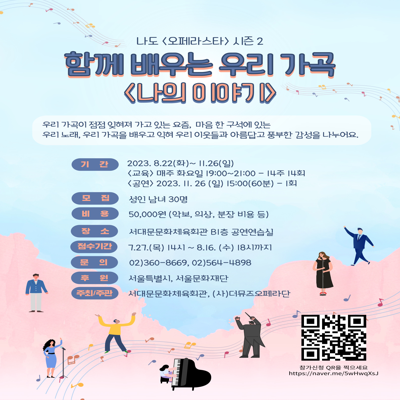

In [31]:
print_response(response)

#### Testing Knowledge Base with Retrieve API
If you need an extra layer of control, you can retrieve the chuncks that best match your query using the retrieve API. In this setup, we can configure the desired number of results and control the final answer with your own application logic. The API then provides you with the matching content, its S3 location, the similarity score and the chunk metadata.

### Clean up
Please make sure to uncomment and run the below section to delete all the resources.

In [35]:
# # Delete resources
print("===============================Deleteing resources ==============================\n")
knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True)

===============================Deleteing resources ==============================

Deleted data source N3BALGGEVC
======== Knowledge base and all data sources deleted =========
Found bucket bedrock-multi-modal-kb-0000300-211125368524
Error deleting bucket bedrock-multi-modal-kb-0000300-211125368524: An error occurred (AccessDenied) when calling the ListObjectVersions operation: User: arn:aws:sts::211125368524:assumed-role/AmazonSageMaker-ExecutionRole-20241227T195512/SageMaker is not authorized to perform: s3:ListBucketVersions on resource: "arn:aws:s3:::bedrock-multi-modal-kb-0000300-211125368524" because no identity-based policy allows the s3:ListBucketVersions action
Found bucket bedrock-multi-modal-kb-0000300-intermediate-0000300-f
Error deleting bucket bedrock-multi-modal-kb-0000300-intermediate-0000300-f: An error occurred (AccessDenied) when calling the ListObjectVersions operation: User: arn:aws:sts::211125368524:assumed-role/AmazonSageMaker-ExecutionRole-20241227T195512/SageMa